In [2]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import StratifiedShuffleSplit

from livelossplot import PlotLosses
from pycm import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset, DataLoader
from torch.utils.data.dataset import Dataset
from torch.autograd import Variable
from torchvision import transforms, datasets, models
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import mode

import math
import time
import copy
from collections import defaultdict

from torchsummary import summary

from obspy.io.segy.segy import _read_segy

#from helper import *

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
    
    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print('Running on GPU')
    device = 'cuda'
else:
    print('Running on CPU')

Running on GPU


In [4]:
from scipy import stats

In [5]:
def make_cylindrical_shale(length, vratio = 0.2, high = 1):
    arr = []
    for i in range(length):
        if i in range(0,10) or i in range(length - 10, length):
            arr.append(0)
        else:
            arr.append(high)
    arr = np.array(arr)
    add = vratio * (np.random.rand(length) + np.random.rand(length) * (-1))
    arr = arr + add
    return arr

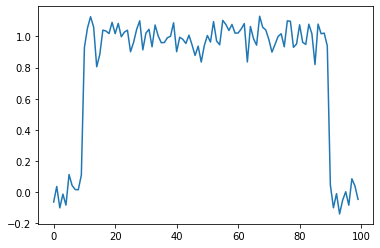

In [23]:
a = make_cylindrical_shale(100)
plt.plot(a)

In [6]:
def make_cylindrical(length, vratio = 0.2, high = 1):
    arr = []
    for i in range(length):
        if i in range(0,10) or i in range(length - 10, length):
            arr.append(high)
        else:
            arr.append(0)
    arr = np.array(arr)
    add = vratio * (np.random.rand(length) + np.random.rand(length) * (-1))
    arr = arr + add
    return arr

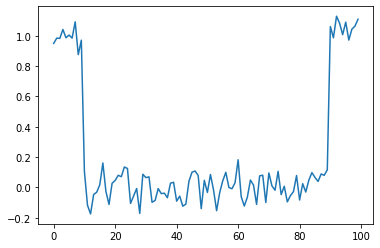

In [25]:
a = make_cylindrical(100)
plt.plot(a)

In [7]:
def make_bell(length, vratio = 0.2, high = 1):
    arr = []
    step = high / length
    num = 0
    i = 0
    while i < length:
        i += 1
        arr.append(num)
        num += step
    arr = np.array(arr)
    add = vratio * (np.random.rand(length) + np.random.rand(length) * (-1))
    arr = arr + add
    return arr

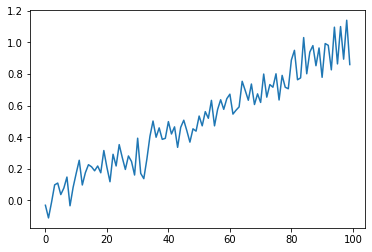

In [8]:
a = make_bell(100)
plt.plot(a)

In [8]:
def make_funnel(length, vratio = 0.2, high = 1):
    arr = []
    step = high / length
    num = 0
    i = 0
    while i < length:
        i += 1
        arr.append(high - num)
        num += step
    arr = np.array(arr)
    add = vratio * (np.random.rand(length) + np.random.rand(length) * (-1))
    arr = arr + add
    return arr

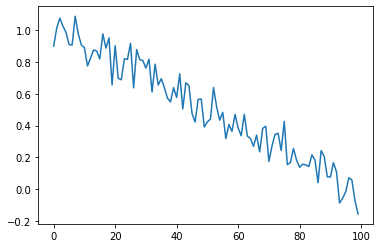

In [10]:
a = make_funnel(100)
plt.plot(a)

In [9]:
def make_symmetrical(length, vratio = 0.2, high = 1, tilt = 0):
    len1 = int((length // 2) * (1-tilt))
    len2 = length - len1
    arr1 = make_funnel(len1)
    arr2 = make_bell(len2)
    arr = np.concatenate((arr1, arr2), axis = 0)
    return arr

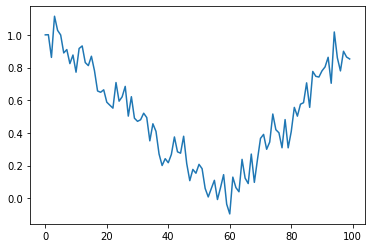

In [12]:
a = make_symmetrical(100, tilt = -0.2)
plt.plot(a)

In [10]:
def make_symmetrical_shale(length, vratio = 0.2, high = 1, tilt = 0):
    len1 = int((length // 2) * (1-tilt))
    len2 = length - len1
    arr1 = make_bell(len1)
    arr2 = make_funnel(len2)
    arr = np.concatenate((arr1, arr2), axis = 0)
    return arr

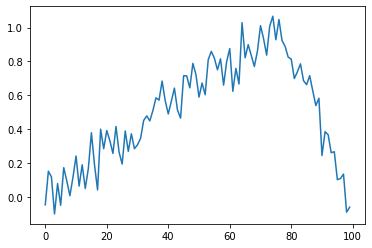

In [14]:
a = make_symmetrical_shale(100, tilt = -0.5)
plt.plot(a)

In [11]:
def make_serrated(length, vratio = 0.5, mid = 0.5):
    arr = []
    for i in range(length):
        arr.append(mid)
    arr = np.array(arr)
    add = vratio * (np.random.rand(length) + np.random.rand(length) * (-1))
    arr = arr + add
    return arr

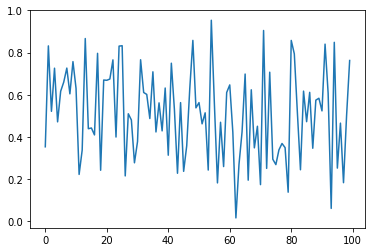

In [16]:
a = make_serrated(100)
plt.plot(a)

###    0 - cylindrical shale, 1 - cylindrical, 2 - bell, 3 - funnel, 4 - symmetrical, 5 - symmetrical shale, 6 - serrated

In [36]:
def prepare_shape_nn_datasets(length = 100, n_samples = 10000):
    train_datasets = []
    train_labels = []
    rand_nums = 0.5 * (np.random.rand(n_samples) + np.random.rand(n_samples) * (-1))
    for i in range(n_samples):
        train_datasets.append(make_cylindrical_shale(length, vratio = 0.2, high = 1))
        train_labels.append(0.)
        train_datasets.append(make_cylindrical(length, vratio = 0.2, high = 1))
        train_labels.append(1.)
        train_datasets.append(make_bell(length, vratio = 0.2, high = 1))
        train_labels.append(2.)
        train_datasets.append(make_funnel(length, vratio = 0.2, high = 1))
        train_labels.append(3.)
        train_datasets.append(make_symmetrical(length, vratio = 0.2, high = 1, tilt = rand_nums[i]))
        train_labels.append(4.)
        train_datasets.append(make_symmetrical_shale(length, vratio = 0.2, high = 1, tilt = rand_nums[i]))
        train_labels.append(5.)
        train_datasets.append(make_serrated(length, vratio = 0.5, mid = 0.5))
        train_labels.append(6.)
    train_datasets = np.array(train_datasets)
    train_labels = np.array(train_labels)
    return train_datasets, train_labels

In [37]:
train_datasets, train_labels = prepare_shape_nn_datasets(length = 100, n_samples = 10000)

In [38]:
print(train_datasets.shape)

(70000, 100)


In [42]:
train_datasets = np.reshape(train_datasets, (70000, 100, 1))

In [47]:
input_tensor = torch.FloatTensor(train_datasets)
output_tensor = torch.LongTensor(train_labels)

In [15]:
batch_size = 128
sequence_length = 100
input_size = 1
hidden_size = 128
num_layers = 2
num_classes = 7
learning_rate = 5e-3
num_epochs = 60

In [49]:
class TrainDataset(Dataset):
    def __init__(self, attributes, classes):
        
        self.attributes = attributes
        self.classes = classes
        self.count = len(self.classes)
    

    def __getitem__(self, index):
        img = self.attributes[index]
        label = self.classes[index]
        return (img, label)
 
    def __len__(self):
        return self.count # number of training objects
    

In [50]:
train_dataset = TrainDataset(input_tensor, output_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [12]:
class Rnn(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_layer, n_class):
        super(Rnn, self).__init__()
        self.n_layer = n_layer
        self.hidden_dim = hidden_dim
        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)
        self.classifier = nn.Linear(hidden_dim, n_class)

    def forward(self, x):
        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),
        #   self.hidden_dim)).cuda()
        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),
        #   self.hidden_dim)).cuda()
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.classifier(out)
        return out

In [59]:
model = Rnn(input_size, hidden_size, num_layers, num_classes).to(device)

In [53]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, size_average=True):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha
        if isinstance(alpha,(float,int)): self.alpha = torch.Tensor([alpha,1-alpha])
        if isinstance(alpha,list): self.alpha = torch.Tensor(alpha)
        self.size_average = size_average

    def forward(self, input, target):
        if input.dim()>2:
            input = input.view(input.size(0),input.size(1),-1)  # N,C,H,W => N,C,H*W
            input = input.transpose(1,2)    # N,C,H*W => N,H*W,C
            input = input.contiguous().view(-1,input.size(2))   # N,H*W,C => N*H*W,C
        target = target.view(-1,1)

        logpt = F.log_softmax(input, dim = 1)
        logpt = logpt.gather(1,target)
        logpt = logpt.view(-1)
        pt = Variable(logpt.data.exp())

        if self.alpha is not None:
            if self.alpha.type()!=input.data.type():
                self.alpha = self.alpha.type_as(input.data)
            at = self.alpha.gather(0,target.data.view(-1))
            logpt = logpt * Variable(at)

        loss = -1 * (1-pt)**self.gamma * logpt
        if self.size_average: return loss.mean()
        else: return loss.sum()

In [13]:
import copy

In [60]:
criterion = FocalLoss(2)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum = 0.5)#optim.Adam(model.parameters(), lr=learning_rate)

In [61]:
pre_loss = 0
for epoch in range(num_epochs):
    pre_model = copy.deepcopy(model.state_dict())
    after_loss = 0
    for i, (image, labels) in enumerate(train_loader):
        image = Variable(image.view(-1, sequence_length, input_size)).cuda()
        labels = Variable(labels).cuda()
        
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print('Epoch [%d/%d], Step [%d/%d, Loss: %.4f'
                  %(epoch+1, num_epochs, i+1, len(train_dataset)//batch_size, loss))
            after_loss += loss
    if epoch == 0:
        pre_loss = after_loss
    else:
        if after_loss > 3 * pre_loss:
            print('Boom!!!!!!')
            model = Rnn(input_size, hidden_size, num_layers, num_classes) 
            model.load_state_dict(pre_model)
            model = model.cuda()
        else:
            pre_loss = after_loss  

Epoch [1/60], Step [100/546, Loss: 1.4290
Epoch [1/60], Step [200/546, Loss: 1.4296
Epoch [1/60], Step [300/546, Loss: 1.4277
Epoch [1/60], Step [400/546, Loss: 1.4285
Epoch [1/60], Step [500/546, Loss: 1.4285
Epoch [2/60], Step [100/546, Loss: 1.4266
Epoch [2/60], Step [200/546, Loss: 1.4256
Epoch [2/60], Step [300/546, Loss: 1.4251
Epoch [2/60], Step [400/546, Loss: 1.4239
Epoch [2/60], Step [500/546, Loss: 1.4242
Epoch [3/60], Step [100/546, Loss: 1.4228
Epoch [3/60], Step [200/546, Loss: 1.4221
Epoch [3/60], Step [300/546, Loss: 1.4212
Epoch [3/60], Step [400/546, Loss: 1.4200
Epoch [3/60], Step [500/546, Loss: 1.4188
Epoch [4/60], Step [100/546, Loss: 1.4176
Epoch [4/60], Step [200/546, Loss: 1.4151
Epoch [4/60], Step [300/546, Loss: 1.4140
Epoch [4/60], Step [400/546, Loss: 1.4128
Epoch [4/60], Step [500/546, Loss: 1.4126
Epoch [5/60], Step [100/546, Loss: 1.4079
Epoch [5/60], Step [200/546, Loss: 1.4039
Epoch [5/60], Step [300/546, Loss: 1.4018
Epoch [5/60], Step [400/546, Loss:

In [62]:
model_save_name = 'shape_distinguisher.pt'
path = model_save_name
torch.save(model.state_dict(), path)

In [16]:
model = Rnn(input_size, hidden_size, num_layers, num_classes)
model_save_name = 'shape_distinguisher.pt'
path = model_save_name
model.load_state_dict(torch.load(path))
model.eval()
model.to(device)

Rnn(
  (lstm): LSTM(1, 128, num_layers=2, batch_first=True)
  (classifier): Linear(in_features=128, out_features=7, bias=True)
)

In [19]:
images = torch.FloatTensor(np.array([make_cylindrical(100), make_serrated(100)]))
images = Variable(images.view(-1, sequence_length, input_size)).cuda()
outputs = model(images)
_,predicted = torch.max(outputs.data,1)

In [20]:
print(predicted)

tensor([1, 6], device='cuda:0')


In [32]:
hh = predicted.cpu().numpy()
print(hh)

[1 6]


In [43]:
print(train_datasets[0][0])

[0.18497007]


4.0


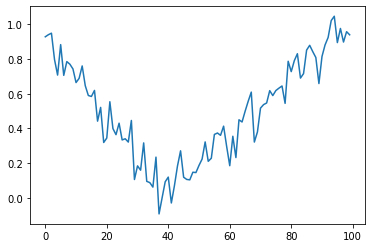

In [40]:
plt.plot(train_datasets[10000+7])
print(train_labels[10000+7])

In [51]:
a = make_cylindrical(100)
b = make_cylindrical(100)
c = make_cylindrical_whale(100) 
d = make_funnel(100)
e = make_bell(100)
f = make_symmetrical(100)
g = make_symmetrical_whale(100)
h = make_serrated(100)

In [52]:
pc = stats.pearsonr(a,b)
sc = stats.spearmanr(a,b)
kc = stats.kendalltau(a,b)
print(pc)
print(sc)
print(kc)

(0.7709498806523809, 6.5159804909201e-21)
SpearmanrResult(correlation=0.12283228322832283, pvalue=0.22341547048932342)
KendalltauResult(correlation=0.0787878787878788, pvalue=0.24545262627337472)


In [53]:
pc = stats.pearsonr(a,c)
sc = stats.spearmanr(a,c)
kc = stats.kendalltau(a,c)
print(pc)
print(sc)
print(kc)

(-0.7664422270422022, 1.5029157553483215e-20)
SpearmanrResult(correlation=-0.08298829882988298, pvalue=0.41172226988788596)
KendalltauResult(correlation=-0.05575757575757576, pvalue=0.4110995299402527)


In [54]:
pc = stats.pearsonr(e,d)
sc = stats.spearmanr(e,d)
kc = stats.kendalltau(e,d)
print(pc)
print(sc)
print(kc)

(-0.9427256917102617, 1.593995939456633e-48)
SpearmanrResult(correlation=-0.9424182418241823, pvalue=2.0567713355777195e-48)
KendalltauResult(correlation=-0.7862626262626264, pvalue=4.586633103931894e-31)


### Well Logs

In [21]:
raw_dataset = []
with open('TRAINING_SET_15WELLS.csv') as training:
    reader = csv.reader(training)
    for row in reader:
        raw_dataset.append(row)
print(len(raw_dataset))

107113


In [22]:
raw_dataset = raw_dataset[1:]

In [23]:
raw_dataset = np.array(raw_dataset)

In [24]:
depth_dataset = raw_dataset[:,1].astype(np.float)
gr_dataset = raw_dataset[:,6].astype(np.float)
output_dataset = raw_dataset[:,-1].astype(np.float)

In [25]:
def normalisation_np_1D(dataset):  
    dataset -= np.mean(dataset)
    dataset /= np.std(dataset)
    return dataset

In [26]:
gr_dataset = normalisation_np_1D(gr_dataset)

In [27]:
well_name_list = []
sorted_well_dataset = []
well_name = 'Default'
sorted_well_temp = []
for i in range(len(raw_dataset)):
    if i == len(raw_dataset)-1:
        sorted_well_temp.append([depth_dataset[i], output_dataset[i], gr_dataset[i]])
        sorted_well_dataset.append(sorted_well_temp)
    elif raw_dataset[i][0] != well_name:
        well_name_list.append(raw_dataset[i][0])
        well_name = raw_dataset[i][0]
        if len(sorted_well_temp) != 0:
            sorted_well_dataset.append(sorted_well_temp)
        sorted_well_temp = [[depth_dataset[i], output_dataset[i], gr_dataset[i]]]
    else: 
        sorted_well_temp.append([depth_dataset[i], output_dataset[i], gr_dataset[i]])

In [28]:
print(well_name_list)

['Grondin_Marine-25_GRM025', 'Akoum-B01_AKM-B01', 'Barbier_Marine-01_BAM-01', 'Barbier_Marine-14_BAM-14', 'Chaillu_Papillon_Marine-01_CHPAM-01', 'Gonelle_Marine-17PH_GNM-17_1PH', 'Guifette_Marine-01_BGFM-01', ' Jabiru_Marine-01_GLJAM-01', 'Ilomba-01_ILO-01', 'Loche_East_Marine-01_LCME-01', 'Mandaros_Marine-19_MAM-19', "M'Pira_Marine-01_MPM-01", 'Octopus_Marine-A03_OCM-A03', 'Hylia_Nord_Marine-01_HYNM-01', 'Oguendjo_West_Marine-C04_OGW-C04']


In [29]:
print(sorted_well_dataset[0][5422])

[1850.75, 1.0, 1.835421010927011]


In [39]:
def MaxMinNormplusAdap(arr, num):
    ds = signal.resample(arr, num)
    max_ds = max(ds)
    min_ds = min(ds)
    arr = (ds - min_ds) / (max_ds - min_ds)
    return arr

In [44]:
from scipy import signal

In [69]:
def get_shape_information(sort_well, model, num_neighbors, sequence_length, input_size):
    shapes = []
    for i in range(len(sorted_well_dataset)):
        cand = np.array(sorted_well_dataset[i])
        temp = []
        for j in range(len(sorted_well_dataset[i]) - num_neighbors):
            sec =  MaxMinNormplusAdap(cand[j:j+num_neighbors,-1], sequence_length)
            images = torch.FloatTensor(sec)
            images = Variable(images.view(-1, sequence_length, input_size)).cuda()
            outputs = model(images)
            _,predicted = torch.max(outputs.data,1)
            temp.append(predicted.cpu().numpy()[0])
        shapes.append(temp)
    return shapes

In [70]:
shapes = get_shape_information(sorted_well_dataset, model, 500,100,1)

In [71]:
print(len(shapes))

15


In [72]:
print(len(shapes[0]))

8615


In [73]:
print(shapes[0])

[2, 2, 2, 2, 6, 2, 0, 0, 0, 6, 0, 0, 0, 0, 2, 0, 0, 0, 0, 2, 0, 0, 0, 6, 0, 0, 0, 0, 6, 6, 0, 6, 6, 6, 6, 0, 6, 6, 0, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 0, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 6, 4, 4, 6, 6, 4, 4, 4, 4, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 

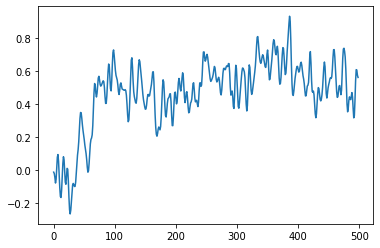

In [68]:
pp = np.array(sorted_well_dataset[0])
plt.plot(pp[21:520, -1])

In [66]:
shape_dataset = []
with open('GR_LABELS_FROM_DL_TRAINING_FILTERED.csv') as training:
    reader = csv.reader(training)
    for row in reader:
        shape_dataset.append(row)
print(len(shape_dataset))

64826


In [80]:
ar1 = np.array(sorted_well_dataset[0][5422:6395])

In [83]:
ar1 = ar1[:,-1]

In [84]:
print(len(ar1))

973


In [85]:
print(ar1)

[ 1.83542101  1.82597114  1.87810834  1.96217956  2.04299221  2.10294998
  2.12510829  2.08176924  1.96022441  1.78914925  1.63338939  1.55583532
  1.57831948  1.66499756  1.75526008  1.81000413  1.83574687  1.85432074
  1.8592086   1.81424028  1.70801075  1.58744349  1.51184456  1.49489997
  1.50728256  1.52878915  1.5636559   1.61383794  1.65489598  1.65619941
  1.61677066  1.5704989   1.56039732  1.60145536  1.67151471  1.73179834
  1.75851865  1.74548435  1.69595402  1.61839995  1.5375873   1.47893296
  1.44374035  1.4196269   1.40691846  1.41930104  1.45612294  1.50206884
  1.53660973  1.53726144  1.49066383  1.4150649   1.35543298  1.34109526
  1.37465857  1.43917835  1.49978784  1.51836171  1.49587755  1.48186568
  1.51608071  1.58027463  1.62850153  1.64316511  1.63371525  1.60438808
  1.55941975  1.53041844  1.55192503  1.61286037  1.66630099  1.69008859
  1.70735903  1.74613607  1.79599226  1.8064197   1.74450678  1.64316511
  1.57375748  1.56528518  1.58092634  1.57603848  1

  0.00605728]


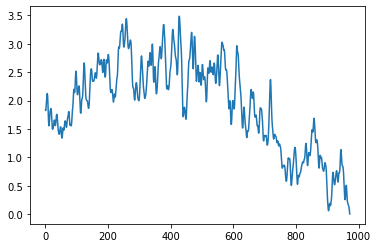

In [86]:
plt.plot(ar1)

In [132]:
def MaxMinNormplusAdap(arr, num):
    ds = signal.resample(arr, num)
    max_ds = max(ds)
    min_ds = min(ds)
    arr = (ds - min_ds) / (max_ds - min_ds)
    return arr

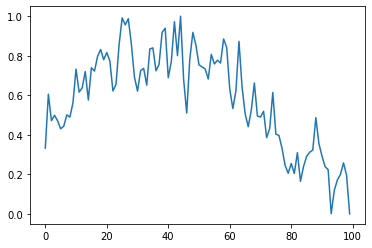

In [133]:
arr2 =  MaxMinNormplusAdap(ar1, 100)
plt.plot(arr2)

In [134]:
images = torch.FloatTensor(arr2)
images = Variable(images.view(-1, sequence_length, input_size)).cuda()
outputs = model(images)
_,predicted = torch.max(outputs.data,1)

In [135]:
print(predicted)

tensor([5], device='cuda:0')


In [114]:
def normalisation_np_1D(dataset):  
    dataset -= np.mean(dataset)
    dataset /= np.std(dataset)
    return dataset

In [115]:
ar3 = normalisation_np_1D(ar1)

In [119]:
ar2 = make_symmetrical_whale(973)
ar4 = make_symmetrical_whale(973, vratio = 0, high = 1, tilt = 0)

In [121]:
ar5 = make_symmetrical_whale(973, vratio = 0.2, high = 10, tilt = 0)

In [123]:
ar6 = make_symmetrical_whale(973, vratio = 0.2, high = 1, tilt = 0.2)

In [125]:
ar7 = make_symmetrical(973)

In [112]:
pc = stats.pearsonr(ar1,ar2)
sc = stats.spearmanr(ar1,ar2)
kc = stats.kendalltau(ar1,ar2)
print(pc)
print(sc)
print(kc)

(-0.5970029149453245, 5.1337690480667454e-95)
SpearmanrResult(correlation=-0.5927874166521412, pvalue=2.240304007847963e-93)
KendalltauResult(correlation=-0.40196679778626776, pvalue=1.2578534670757334e-78)


In [122]:
pc = stats.pearsonr(ar1,ar5)
sc = stats.spearmanr(ar1,ar5)
kc = stats.kendalltau(ar1,ar5)
print(pc)
print(sc)
print(kc)

(-0.5830050762853745, 1.1583290746806822e-89)
SpearmanrResult(correlation=-0.5844423164679204, pvalue=3.358405816194578e-90)
KendalltauResult(correlation=-0.3968023693115265, pvalue=1.1455612363963835e-76)


In [124]:
pc = stats.pearsonr(ar1,ar6)
sc = stats.spearmanr(ar1,ar6)
kc = stats.kendalltau(ar1,ar6)
print(pc)
print(sc)
print(kc)

(-0.6989867558326237, 1.492232339144646e-143)
SpearmanrResult(correlation=-0.7086282031765524, pvalue=3.140664372541826e-149)
KendalltauResult(correlation=-0.49608544022684264, pvalue=9.462296504422372e-119)


In [120]:
pc = stats.pearsonr(ar1,ar4)
sc = stats.spearmanr(ar1,ar4)
kc = stats.kendalltau(ar1,ar4)
print(pc)
print(sc)
print(kc)

(-0.5929865783659505, 1.8766186522522667e-93)
SpearmanrResult(correlation=-0.5901168170664135, pvalue=2.3807961156503972e-92)
KendalltauResult(correlation=-0.3997166127342102, pvalue=9.045844741818514e-78)


In [126]:
pc = stats.pearsonr(ar1,ar7)
sc = stats.spearmanr(ar1,ar7)
kc = stats.kendalltau(ar1,ar7)
print(pc)
print(sc)
print(kc)

(0.5937045341022362, 9.899249888031658e-94)
SpearmanrResult(correlation=0.5933631368810688, pvalue=1.3420679557947546e-93)
KendalltauResult(correlation=0.40300306721813645, pvalue=5.0516565334146345e-79)


In [128]:
a = make_cylindrical(973)
b = make_cylindrical(973)
c = make_cylindrical_whale(973) 
d = make_funnel(973)
e = make_bell(973)
h = make_serrated(973)

In [129]:
pc = stats.pearsonr(ar1,a)
sc = stats.spearmanr(ar1,a)
kc = stats.kendalltau(ar1,a)
print(pc)
print(sc)
print(kc)

(0.0405180887730659, 0.20667093028796155)
SpearmanrResult(correlation=0.028078087057589383, pvalue=0.38163650670244664)
KendalltauResult(correlation=0.018200274960533596, pvalue=0.39532443191556443)


In [130]:
pc = stats.pearsonr(ar1,b)
sc = stats.spearmanr(ar1,b)
kc = stats.kendalltau(ar1,b)
print(pc)
print(sc)
print(kc)

(0.034469653504858415, 0.2827567200431137)
SpearmanrResult(correlation=0.011181344150378584, pvalue=0.7275836271039267)
KendalltauResult(correlation=0.00690705298874073, pvalue=0.7470150705626739)


In [131]:
pc = stats.pearsonr(ar1,c)
sc = stats.spearmanr(ar1,c)
kc = stats.kendalltau(ar1,c)
print(pc)
print(sc)
print(kc)

(-0.05537210531157757, 0.0842892288994168)
SpearmanrResult(correlation=-0.0418814858065795, pvalue=0.19179056942036465)
KendalltauResult(correlation=-0.028089246110365697, pvalue=0.1895733179547855)


In [132]:
pc = stats.pearsonr(ar1,d)
sc = stats.spearmanr(ar1,d)
kc = stats.kendalltau(ar1,d)
print(pc)
print(sc)
print(kc)

(-0.5949359014503357, 3.292756086463878e-94)
SpearmanrResult(correlation=-0.5588346175625458, pvalue=5.228424625769485e-81)
KendalltauResult(correlation=-0.3777138634093913, pvalue=1.2094501266583263e-69)


In [133]:
pc = stats.pearsonr(ar1,e)
sc = stats.spearmanr(ar1,e)
kc = stats.kendalltau(ar1,e)
print(pc)
print(sc)
print(kc)

(0.5866454932012544, 4.973347326856494e-91)
SpearmanrResult(correlation=0.5509955759089827, pvalue=2.372220865904314e-78)
KendalltauResult(correlation=0.36579042043617627, pvalue=1.9733440563796065e-65)


In [134]:
pc = stats.pearsonr(ar1,h)
sc = stats.spearmanr(ar1,h)
kc = stats.kendalltau(ar1,h)
print(pc)
print(sc)
print(kc)

(0.015613309724460445, 0.626663202338495)
SpearmanrResult(correlation=0.014836287306872517, pvalue=0.643924933391232)
KendalltauResult(correlation=0.009444855679031262, pvalue=0.6591407165552158)


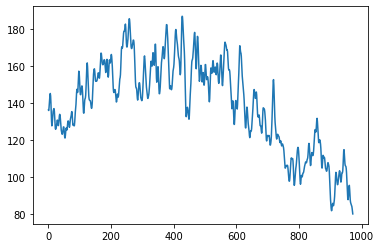

In [113]:
plt.plot(ar1)

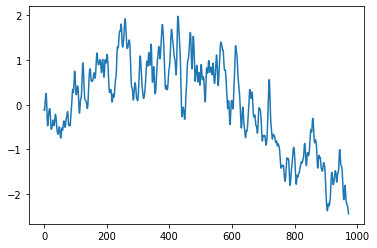

In [118]:
plt.plot(ar3)

In [1]:
def shape_distinguisher(array):
    length = len(array)
    shape_candidates1 = [make_cylindrical(length), make_cylindrical_shale(length), make_funnel(length), make_bell(length), make_serrated(length)]
    scores = []
    
    for shape in shape_candidates1:
        pc = stats.pearsonr(array, shape)[0]
        sc = stats.spearmanr(array, shape)[0]
        kc = stats.kendalltau(array, shape)[0]
        scores.append((pc+sc+kc)/3)
        
    angles = np.arange(-0.5, 0.6, 0.1)
    
    for i in range(len(angles)):
        f = make_symmetrical(length, tilt = angles[i])
        pc = stats.pearsonr(array, f)[0]
        sc = stats.spearmanr(array, f)[0]
        kc = stats.kendalltau(array, f)[0]
        scores.append((pc+sc+kc)/3)
        
        g = make_symmetrical_shale(length, tilt = angles[i])
        pc = stats.pearsonr(array, g)[0]
        sc = stats.spearmanr(array, g)[0]
        kc = stats.kendalltau(array, g)[0]
        scores.append((pc+sc+kc)/3)
    
    max_score = 0
    position = 0

    for i in range(len(scores)):
        if scores[i] > max_score:
            max_score = scores[i]
            position = i
    
    shape = None
    if position == 0:
        shape = 'Cylindrical'
    elif position == 1:
        shape = 'Cylindrical Shale'
    elif position == 2:
        shape = 'Funnel'
    elif position == 3:
        shape = 'Bell'
    elif position == 4:
        shape = 'Serrated'
    elif position >=5 and position %2 == 1:
        shape = 'Symmetrical'
    else:
        shape = 'Symmetrical Shale'
    
    return shape, max_score   

In [136]:
shape_dataset = []
with open('GR_LABELS_FROM_DL_TRAINING_FILTERED.csv') as training:
    reader = csv.reader(training)
    for row in reader:
        shape_dataset.append(row)
print(len(shape_dataset))

64826


In [157]:
train_well_name = ['GRM025', 'Akoum-B01', 'Barbier_Marine-01', 'Barbier_Marine-14', 'Chaillu_Papillon_Marine-01', 'Gonelle_Marine-17PH',
                  'Guifette_Marine-01', 'Jabiru_Marine-01', 'Ilomba-01', 'Loche_East_Marine-01', 'Mandaros_Marine-19', "M'Pira_Marine-01",
                  'Octopus_Marine-A03', 'HYNM-01', 'Oguendjo_West_Marine-C04']

In [158]:
well_indices = []
for item in train_well_name:
    for i in range(len(Well_total)):
        if item in Well_total[i]:
            well_indices.append(i)
print(well_indices)

[0, 2, 3, 5, 8, 11, 12, 13, 15, 16, 17, 24, 27, 33, 36]


In [137]:
import re

Well_total = []
for item in shape_dataset:
    matchobj = re.match(r'\$Well : (.*?) .*', item[0])
    if matchobj:
        print(matchobj.group(1))
        Well_total.append(matchobj.group(1))

GRM025
GSM002
Akoum-B01
Barbier_Marine-01
Barbier_Marine-07
Barbier_Marine-14
Barbier_Marine-20ST
Chaillu_Hirondelle_Marine-01
Chaillu_Papillon_Marine-01
Girelle_Marine-01
Gombe_South_Marine-B02
Gonelle_Marine-17PH
Guifette_Marine-01
Jabiru_Marine-01
Lamproie_North_Marine-01
Ilomba-01
Loche_East_Marine-01
Mandaros_Marine-19
Mandaros_West_Marine-01
Manga_Marine-01
Mitshogo-01
Mosen_A_Marine-01
Mouveni_Marine-01
M'Pando_Marine-01
M'Pira_Marine-01
N'Komi_Aigle_Marine-01
Nombo_Marine-01
Octopus_Marine-A03
Oguendjo_West_Marine-C03
Tchatamba_South-B03
Turnix_Marine-A01
Girelle_Marine-05
Pageau_Marine-05
HYNM-01
Ombrette_Marine-01
Vanneau_Marine-02
Oguendjo_West_Marine-C04
Oguendjo_West_Marine-B01
Oguendjo_West_Marine-Z01
Ablette_West_Marine-01GST
Gardon_Marine-01
Inguessi_Marine_B-06
Pelican_Marine-A01A


In [168]:
sep_well_dataset = []
index = 0
well_temp = []

for i in range(len(shape_dataset)):
    if index >= len(Well_total):
        findex = i
        break
    else:
        if Well_total[index] in shape_dataset[i][0]:
            if len(well_temp) != 0:
                sep_well_dataset.append(well_temp)
                well_temp = []  
            index += 1
        else:
            well_temp.append(shape_dataset[i])
        
    
    
    
for j in range(findex, len(shape_dataset)):
    well_temp.append(shape_dataset[j])
sep_well_dataset.append(well_temp)
    
    
print(len(sep_well_dataset))

43


In [150]:
print(well_name_list)

['Grondin_Marine-25_GRM025', 'Akoum-B01_AKM-B01', 'Barbier_Marine-01_BAM-01', 'Barbier_Marine-14_BAM-14', 'Chaillu_Papillon_Marine-01_CHPAM-01', 'Gonelle_Marine-17PH_GNM-17_1PH', 'Guifette_Marine-01_BGFM-01', ' Jabiru_Marine-01_GLJAM-01', 'Ilomba-01_ILO-01', 'Loche_East_Marine-01_LCME-01', 'Mandaros_Marine-19_MAM-19', "M'Pira_Marine-01_MPM-01", 'Octopus_Marine-A03_OCM-A03', 'Hylia_Nord_Marine-01_HYNM-01', 'Oguendjo_West_Marine-C04_OGW-C04']


In [169]:
filtered_sep_well = []

for i in range (len(sep_well_dataset)):
    if i in well_indices:
        filtered_sep_well.append(np.array(sep_well_dataset[i][1:]).astype(np.float))

In [170]:
print(filtered_sep_well[0])

[[ 1850.7456     6.    ]
 [ 1850.898      6.    ]
 [ 1851.0504     6.    ]
 ..., 
 [ 2364.3336     0.    ]
 [ 2364.486      0.    ]
 [ 2364.6384     0.    ]]


In [220]:
print(len(filtered_sep_well[0]))

1859


In [235]:
print(sorted_well_dataset[0][1000])

[1176.8299999999999, 0.0, 0.31399256807732284]


In [194]:
def get_chunkindices_and_labels(well):
    indices = []
    label_list = []
    label = well[0][1]
    index1 = 0
    
    for i in range(len(well)):
        if well[i][1] != label:
            indices.append([index1, i])
            label_list.append(label)
            label = well[i][1]
            index1 = i
    indices.append([index1, len(well)])
    label_list.append(label)
    
    return indices,label_list  

In [195]:
e,g = get_chunkindices_and_labels(filtered_sep_well[0])

In [226]:
print(e)
print(g)

[[0, 973], [973, 1498], [1498, 1859]]
[6.0, 4.0, 0.0]


In [228]:
print(start + e[0][1])

973


In [230]:
start = 0
ah = np.array(sorted_well_dataset[0])
print(len(ah))
print(ah[start + e[0][0]: start + e[0][1], -1])

9115
[ 0.31008228  0.25990023  0.21167333  0.18593059  0.18723402  0.19831317
  0.20417861  0.22275248  0.27228281  0.31790286  0.29802555  0.21004404
  0.12727625  0.10902823  0.13868126  0.16018785  0.15204141  0.13183825
  0.11261266  0.08198206  0.03245173 -0.01382003 -0.02229232 -0.04607992
 -0.07964323 -0.05683321  0.01192271  0.07611663  0.09273536  0.05069975
 -0.02848361 -0.10864455 -0.1611076  -0.16729889 -0.12298227 -0.04379891
  0.03668788  0.0793752   0.06112719 -0.00697702 -0.07442951 -0.08713796
 -0.04119205  0.00898999  0.00410213 -0.06758651 -0.16664717 -0.24192024
 -0.26668541 -0.24354953 -0.19043477 -0.13178043 -0.09267753 -0.08225009
 -0.09007067 -0.10049811 -0.10017225 -0.0737778  -0.01805618  0.04483431
  0.08915093  0.12141081  0.16931186  0.24034878  0.30943056  0.34755589
  0.34527488  0.31334085  0.27228281  0.23904535  0.21297676  0.18364959
  0.15041213  0.12336596  0.09925251  0.06308233  0.01648471 -0.01414589
 -0.00567359  0.04027231  0.10348865  0.157255

  0.12206253]


In [231]:
def chunkize(sep_well, sort_well, tol = 0.01):
    gr_chunks = []
    depth_chunks = []
    labels = []
    for i in range(len(sort_well)):
        indi, lab = get_chunkindices_and_labels(filtered_sep_well[i])
        b_gr_chunk = []
        b_d_chunk = []
        found = False
        cand = np.array(sort_well[i])
        for j in range(len(sort_well[i])):
            for k in range(len(sep_well[i])):
                if abs(sep_well[i][k][0] - sort_well[i][j][0]) < tol:
                    start = j

                    for m in range(len(indi)):
                        b_gr_chunk.append(cand[start + indi[m][0]: start + indi[m][1],-1])
                        b_d_chunk.append(cand[start + indi[m][0]: start + indi[m][1],0])
                    found = True
                    break
            if found == True:
                break
        gr_chunks.append(b_gr_chunk)
        depth_chunks.append(b_d_chunk)
        labels.append(lab)
        print(i)
    return gr_chunks, depth_chunks, labels

In [232]:
g1,d1,l1 = chunkize(filtered_sep_well, sorted_well_dataset, tol = 0.01)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


In [237]:
print(l1)

[[6.0, 4.0, 0.0], [1.0, 4.0, 0.0, 4.0, 0.0, 4.0], [0.0, 1.0, 0.0], [2.0, 0.0], [0.0, 4.0], [2.0, 0.0, 2.0, 0.0], [0.0, 7.0, 0.0, 1.0, 4.0], [0.0, 4.0, 0.0], [6.0, 0.0, 5.0], [6.0, 7.0, 4.0, 0.0], [2.0, 0.0], [6.0, 4.0], [0.0, 2.0, 3.0], [0.0, 7.0, 0.0, 4.0], [7.0, 0.0, 1.0, 4.0, 1.0, 4.0]]


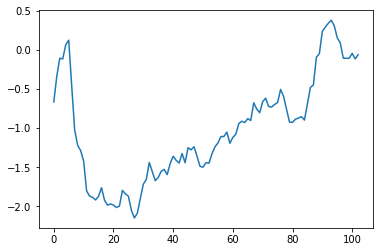

In [239]:
plt.plot(g1[1][0])

In [18]:
arr2 =  MaxMinNormplusAdap(g1[3][0], 100)
plt.plot(arr2)

NameError: name 'MaxMinNormplusAdap' is not defined

In [260]:
images = torch.FloatTensor(arr2)
images = Variable(images.view(-1, sequence_length, input_size)).cuda()
outputs = model(images)
_,predicted = torch.max(outputs.data,1)

In [261]:
print(predicted)

tensor([1], device='cuda:0')


In [262]:
print(outputs)

tensor([[-3.5501,  4.3956, -1.9112, -0.6051,  0.7445, -0.3880,  1.3315]],
       device='cuda:0', grad_fn=<AddmmBackward>)


#### Use this shape distinguisher model before taining the classification model and get some outputs. After that add it into the CNN/RNN models.

In [17]:
images = torch.FloatTensor(np.array([arr2, arr2]))
images = Variable(images.view(-1, sequence_length, input_size)).cuda()
outputs = model(images)
_,predicted = torch.max(outputs.data,1)

NameError: name 'arr2' is not defined